In [33]:
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib
import pandas as pd
import seaborn as sns
from data_analysis_preparation.utils import (base_volumetric_columns,
                                             get_bounding_box,
                                             get_mci_progression,
                                             get_mean_image_per_diagnosis,
                                             load_adnimerge)

### Load data

In [34]:
ADNIMERGE_PATH = "/Users/michaelhase/Desktop/ADNI_Proj/data/All_Subjects_Tables/ADNIMERGE.csv"
images_directory = "/Users/michaelhase/Desktop/SeniorThesis/data/ADNI/"

In [35]:
df_adnimerge = load_adnimerge(ADNIMERGE_PATH)
print(df_adnimerge[['IMAGEUID']].head())

   IMAGEUID
0     35475
1     32237
2     31863
3     35576
4     88252


In [36]:
images_directory = Path(images_directory)
if not images_directory.exists():
    print(f"Directory {images_directory} does not exist!")

    # Find all .nii images in the directory
scans_paths = list(images_directory.rglob("*.nii"))
print(f"Found {len(scans_paths)} images")

paths_by_imageuid = {}
for pth in scans_paths:
        # Debugging: print the filenames we're processing
    print(f"Processing file: {pth.name}")

        # Extract the IMAGEUID as an integer from the filename (after '_I')
    try:
        imageuid = int(pth.name.split("_I")[-1].split(".")[0])
        paths_by_imageuid[imageuid] = pth
    except (IndexError, ValueError) as e:
        print(f"Error with file {pth}: {e}")

print(f"Mapped {len(paths_by_imageuid)} images by IMAGEUID")

    # Debugging: Print a sample of the paths_by_imageuid to verify
print(f"Sample paths_by_imageuid: {list(paths_by_imageuid.items())[:5]}")

    # Map the IMAGEUID in the DataFrame to the paths
df_adnimerge['path'] = df_adnimerge['IMAGEUID'].map(paths_by_imageuid)
    
    # Debugging: Print how many matches were found before dropping NaN values
print(f"Total matches found: {df_adnimerge['path'].notna().sum()} out of {len(df_adnimerge)}")

    # Drop rows where 'path' is NaN
df_adnimerge = df_adnimerge.dropna(subset=['path'])
    


Found 952 images
Processing file: ADNI_031_S_0351_MR_MPR__GradWarp__N3__Scaled_Br_20080207173709466_S21905_I89948.nii
Processing file: ADNI_031_S_0351_MR_MPR__GradWarp__N3__Scaled_Br_20070807160423440_S32191_I65620.nii
Processing file: ADNI_031_S_0351_MR_MPR-R__GradWarp__N3__Scaled_Br_20070807100818129_S13461_I65401.nii
Processing file: ADNI_100_S_0006_MR_MPR____N3__Scaled_Br_20061213150829798_S15294_I33034.nii
Processing file: ADNI_100_S_0006_MR_MPR____N3__Scaled_Br_20070727123814803_S23093_I62348.nii
Processing file: ADNI_100_S_0006_MR_MPR____N3__Scaled_Br_20061213150005090_S10145_I33025.nii
Processing file: ADNI_041_S_1423_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20081017080327353_S55787_I121666.nii
Processing file: ADNI_041_S_1423_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070910181109848_S36902_I72232.nii
Processing file: ADNI_041_S_1423_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20080223162436122_S45367_I91810.nii
Processing file: ADNI_073_S_0312_MR_MPR__Gra

## Data analysis

Number of rows: 767
Number of unique subjects: 257
Minimal age: 55.1
Maximal age: 89.3
Age distribution:


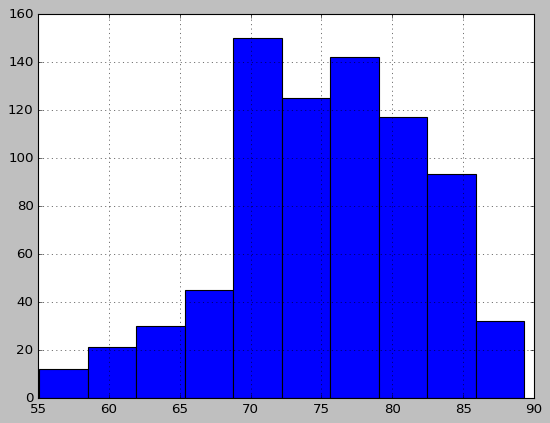

In [37]:
print(f"Number of rows: {len(df_adnimerge)}")
print(f"Number of unique subjects: {len(df_adnimerge.groupby('PTID'))}")
print(f"Minimal age: {df_adnimerge['AGE'].min()}")
print(f"Maximal age: {df_adnimerge['AGE'].max()}")
print(f"Age distribution:")
age_hist = df_adnimerge['AGE'].hist()
fig = age_hist.get_figure()
fig.savefig("ADNI_age_histogram")

In [38]:
print(f"Gender distribution per scan:")
print(df_adnimerge['PTGENDER'].value_counts())
print(f"Genders distribution per subject:")
print(df_adnimerge[["PTID", "PTGENDER"]].drop_duplicates()['PTGENDER'].value_counts())

Gender distribution per scan:
PTGENDER
Male      445
Female    322
Name: count, dtype: int64
Genders distribution per subject:
PTGENDER
Male      149
Female    108
Name: count, dtype: int64


Diagnosis distribution per subject:
DX
MCI    160
AD      71
CN      63
Name: count, dtype: int64


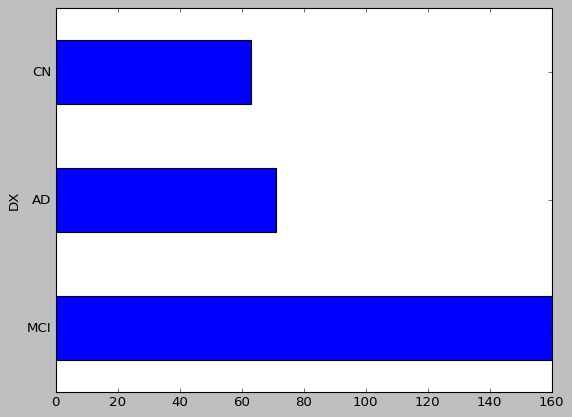

In [39]:
print(f"Diagnosis distribution per subject:")
print(df_adnimerge[["PTID", "DX"]].drop_duplicates()["DX"].value_counts())
diag_plot = df_adnimerge[["PTID", "DX"]].drop_duplicates()["DX"].value_counts().plot.barh()
fig = diag_plot.get_figure()
fig.savefig("ADNI_diagnosis_persubject_plot")

Diagnosis distribution per scan:
DX
MCI    430
CN     183
AD     154
Name: count, dtype: int64


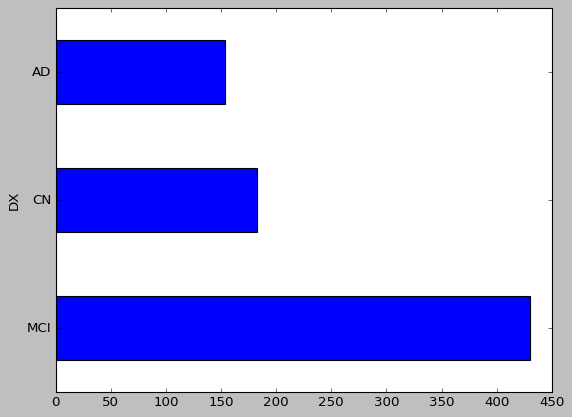

In [40]:
print("Diagnosis distribution per scan:")
print(df_adnimerge["DX"].value_counts())
diag_plot = df_adnimerge["DX"].value_counts().plot.barh()
fig = diag_plot.get_figure()
fig.savefig("ADNI_diagnosis_perscan_plot")

Diagnosis distribution per gender on baseline visit:


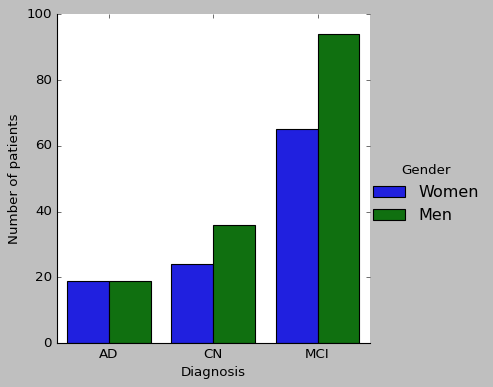

In [41]:
print("Diagnosis distribution per gender on baseline visit:")
df_plot = df_adnimerge[df_adnimerge['VISCODE'] == "bl"]
plot_data = df_plot[["DX", "PTGENDER"]].groupby(["DX", "PTGENDER"]).size().reset_index(name="count")
#plot_data
plot_data.columns = ["Diagnosis", "Gender", "Number of patients"]
plot_data["Gender"] = plot_data["Gender"].map({"Male": "Men", "Female": "Women"})
plt.style.use('classic')
sns.catplot(x="Diagnosis", y="Number of patients", hue="Gender", data=plot_data, kind="bar").savefig("ADNI_diagnosis_gender")


### Subjects age distribution

In [42]:
df_patients = df_adnimerge[["PTID", "PTGENDER", "AGE", "DX"]].groupby("PTID").agg({"PTGENDER": "first", "AGE": "mean", "DX": "first"})
# Round the age values and then convert to integers
df_patients['AGE'] = df_patients['AGE'].fillna(df_patients['AGE'].mean()).round().astype(int)



In [43]:
pd.DataFrame({"age_AD": df_patients[df_patients["DX"] == "AD"]["AGE"].describe().round(2),
 "age_AD_female": df_patients[(df_patients["DX"] == "AD") & (df_patients['PTGENDER'] == "Female")]["AGE"].describe().round(2),
 "age_AD_male": df_patients[(df_patients["DX"] == "AD") & (df_patients['PTGENDER'] == "Male")]["AGE"].describe().round(2)
 })


,age_AD,age_AD_female,age_AD_male
count,39.00,19.00,20.00
mean,73.69,73.53,73.85
std,7.53,8.06,7.20
min,55.00,55.00,63.00
25%,69.00,70.00,68.75
50%,72.00,76.00,71.00
75%,79.50,79.50,80.00
max,87.00,84.00,87.00


In [44]:
pd.DataFrame({"age_MCI": df_patients[df_patients["DX"] == "MCI"]["AGE"].describe().round(2),
 "age_MCI_female": df_patients[(df_patients["DX"] == "MCI") & (df_patients['PTGENDER'] == "Female")]["AGE"].describe().round(2),
 "age_MCI_male": df_patients[(df_patients["DX"] == "MCI") & (df_patients['PTGENDER'] == "Male")]["AGE"].describe().round(2)
 })

,age_MCI,age_MCI_female,age_MCI_male
count,157.00,65.00,92.00
mean,75.13,73.85,76.03
std,7.01,6.59,7.19
min,57.00,57.00,58.00
25%,70.00,69.00,71.00
50%,76.00,74.00,76.50
75%,80.00,79.00,81.00
max,89.00,86.00,89.00


In [45]:
pd.DataFrame({"age_CN": df_patients[df_patients["DX"] == "CN"]["AGE"].describe().round(2),
              "age_CN_female": df_patients[(df_patients["DX"] == "CN") & (df_patients['PTGENDER'] == "Female")][
                  "AGE"].describe().round(2),
              "age_CN_male": df_patients[(df_patients["DX"] == "CN") & (df_patients['PTGENDER'] == "Male")][
                  "AGE"].describe().round(2)
              })

,age_CN,age_CN_female,age_CN_male
count,61.00,24.00,37.00
mean,76.16,76.04,76.24
std,5.21,5.13,5.34
min,63.00,70.00,63.00
25%,72.00,72.75,72.00
50%,76.00,74.50,76.00
75%,79.00,78.25,79.00
max,89.00,89.00,89.00


In [46]:
df_mci_progression = get_mci_progression(df_adnimerge)
pd.DataFrame({"age_p-MCI": df_mci_progression[df_mci_progression["DX"] == "p-MCI"]["AGE"].describe().round(2),
              "age_p-MCI_female": df_mci_progression[(df_mci_progression["DX"] == "p-MCI") & (df_mci_progression['PTGENDER'] == "Female")][
                  "AGE"].describe().round(2),
              "age_p-MCI_male": df_mci_progression[(df_mci_progression["DX"] == "p-MCI") & (df_mci_progression['PTGENDER'] == "Male")][
                  "AGE"].describe().round(2)
              })

,age_p-MCI,age_p-MCI_female,age_p-MCI_male
count,58.00,26.00,32.00
mean,74.71,74.05,75.24
std,6.84,6.37,7.26
min,56.60,56.60,59.40
25%,70.53,72.50,69.90
50%,75.20,74.80,75.60
75%,79.70,79.10,79.88
max,85.90,81.00,85.90


In [47]:
df_mci_progression = get_mci_progression(df_adnimerge)
pd.DataFrame({"age_p-MCI": df_mci_progression[df_mci_progression["DX"] == "np-MCI"]["AGE"].describe().round(2),
              "age_p-MCI_female": df_mci_progression[(df_mci_progression["DX"] == "np-MCI") & (df_mci_progression['PTGENDER'] == "Female")][
                  "AGE"].describe().round(2),
              "age_p-MCI_male": df_mci_progression[(df_mci_progression["DX"] == "np-MCI") & (df_mci_progression['PTGENDER'] == "Male")][
                  "AGE"].describe().round(2)
              })

,age_p-MCI,age_p-MCI_female,age_p-MCI_male
count,372.00,147.00,225.00
mean,75.43,73.79,76.50
std,7.09,6.81,7.08
min,57.70,59.80,57.70
25%,70.00,69.10,71.40
50%,76.40,74.40,77.10
75%,80.40,78.90,81.40
max,89.30,86.20,89.30


### Anatomical structures volumes per diagnosis


In [48]:
df_patients = df_adnimerge[df_adnimerge["VISCODE"] == "bl"]
anatomical_structures_columns = ["PTID", "PTGENDER", "DX", "MMSE"] + base_volumetric_columns
df_patients = df_patients[anatomical_structures_columns]

In [49]:
print("CN")
df_patients[df_patients["DX"] == "CN"].describe().round(2).loc[["min", "max", "std"]]

CN


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,25.00,5834.00,5381.00,793659.00,2789.00,12814.0,14746.00,1227680.00
max,30.00,100808.00,9146.00,1200530.00,5317.00,21729.0,25290.00,1845780.00
std,1.24,19942.46,738.71,100267.91,626.74,2291.6,2631.93,153849.37


In [50]:
print("MCI")
df_patients[df_patients["DX"] == "MCI"].describe().round(2).loc[["min", "max", "std"]]

MCI


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,23.00,10739.00,3281.00,669364.00,1579.00,10467.00,10472.00,1175130.00
max,30.00,145115.00,9104.00,1350180.00,5660.00,21062.00,26426.00,2110290.00
std,1.81,24271.29,1086.75,108685.87,810.81,2326.14,3043.97,164131.37


In [51]:
print("AD")
df_patients[df_patients["DX"] == "AD"].describe().round(2).loc[["min", "max", "std"]]

AD


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,20.00,12361.00,4023.00,750109.00,1893.0,11129.00,11760.00,1214530.00
max,27.00,83680.00,7350.00,1186600.00,4421.0,20881.00,21101.00,1957220.00
std,1.54,17839.27,836.85,106495.95,641.0,2532.97,2747.09,177165.65


In [52]:
print("p-MCI")
df_mci_progression = df_mci_progression[df_mci_progression["VISCODE"] == "bl"][anatomical_structures_columns]
df_mci_progression[df_mci_progression["DX"] == "p-MCI"].describe().round(2).loc[["min", "max", "std"]]

p-MCI


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,23.00,10739.0,3281.00,669364.00,1579.00,10894.00,10472.00,1175130.00
max,30.00,101096.0,8585.00,1350180.00,4617.00,21062.00,26379.00,2110290.00
std,1.94,20287.3,1051.36,124447.36,769.38,2455.43,3478.44,184469.81


In [53]:
print("np-MCI")
df_mci_progression[df_mci_progression["DX"] == "np-MCI"].describe().round(2).loc[["min", "max", "std"]]

np-MCI


,MMSE,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
min,24.00,12348.00,4404.00,738813.00,1621.00,10467.00,10708.00,1228080.00
max,30.00,145115.00,9104.00,1208430.00,5660.00,19928.00,26426.00,2040440.00
std,1.75,25166.77,1053.43,103952.91,790.23,2197.18,2834.08,159111.87


## Analysis of preprocessed imaging data

In [54]:
print(df_adnimerge[['IMAGEUID', 'path']].head())


    IMAGEUID                                               path
5      64631  /Users/michaelhase/Desktop/SeniorThesis/data/A...
6      64636  /Users/michaelhase/Desktop/SeniorThesis/data/A...
7      59357  /Users/michaelhase/Desktop/SeniorThesis/data/A...
15     33025  /Users/michaelhase/Desktop/SeniorThesis/data/A...
16     33034  /Users/michaelhase/Desktop/SeniorThesis/data/A...


In [55]:
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def resize_image(image: np.ndarray, target_shape: tuple) -> np.ndarray:
    """
    Resize a 2D image to the target shape using zoom.

    :param image: The 2D image to resize.
    :param target_shape: The desired shape to resize the image to.
    :return: The resized image.
    """
    factors = [t / s for t, s in zip(target_shape, image.shape)]
    return zoom(image, factors, order=1)  # order=1 for bilinear interpolation

def get_mean_image_per_diagnosis(df, target_shape=(182, 218)):
    # Initialize arrays to hold sum of images for each diagnosis
    ad_scans = np.zeros(target_shape)
    mci_scans = np.zeros(target_shape)
    cn_scans = np.zeros(target_shape)

    # Counters for each diagnosis group
    ad_scans_num = 0
    mci_scans_num = 0
    cn_scans_num = 0

    for _, row in df.iterrows():
        # Load the image file
        image = nib.load(row['path']).get_fdata()

        # Extract a specific slice (here it's the 80th slice)
        image_slice = image[:, :, 80]  # Adjust the slice index as needed

        # Resize the slice to the target shape (182x218 by default)
        resized_slice = resize_image(image_slice, target_shape)

        # Add the resized slice to the corresponding diagnosis group
        if row['DX'] == 'AD':
            ad_scans += resized_slice
            ad_scans_num += 1
        elif row['DX'] == 'MCI':
            mci_scans += resized_slice
            mci_scans_num += 1
        elif row['DX'] == 'CN':
            cn_scans += resized_slice
            cn_scans_num += 1
        else:
            print(f'Unknown diagnosis {row["DX"]}')

    # Calculate the mean image for each diagnosis
    ad_mean = ad_scans / ad_scans_num if ad_scans_num > 0 else None
    mci_mean = mci_scans / mci_scans_num if mci_scans_num > 0 else None
    cn_mean = cn_scans / cn_scans_num if cn_scans_num > 0 else None

    return ad_mean, mci_mean, cn_mean



In [56]:
ad_mean, mci_mean, cn_mean = get_mean_image_per_diagnosis(df_adnimerge)

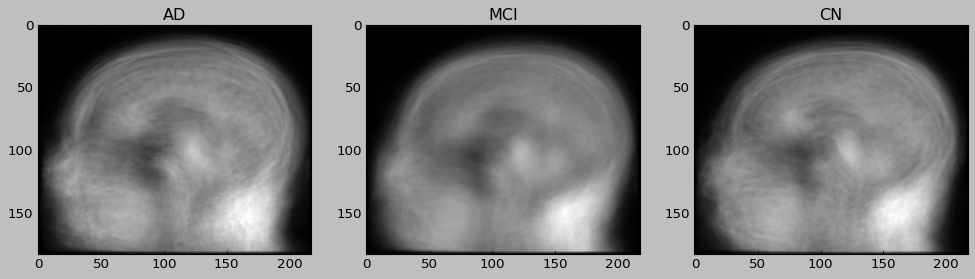

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ad_mean, cmap='gray')
axes[0].set_title('AD')
axes[1].imshow(mci_mean, cmap='gray')
axes[1].set_title('MCI')
axes[2].imshow(cn_mean, cmap='gray')
axes[2].set_title('CN')
plt.savefig('ADNI_mean_scans.png')

In [58]:
df_adnimerge[["xmin", "xmax", "ymin", "ymax", "zmin", "zmax", "width", "height", "depth", "min_val", "max_val"]] = df_adnimerge.apply(lambda row: get_bounding_box(nib.load(row['path']).get_fdata()), axis=1, result_type="expand")
df_adnimerge[["xmin", "xmax", "ymin", "ymax", "zmin", "zmax", "width", "height", "depth", "min_val", "max_val"]].describe()

,xmin,xmax,ymin,ymax,zmin,zmax,width,height,depth,min_val,max_val
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.0,767.000000
mean,9.379400,227.413299,2.340287,226.284224,0.654498,164.496741,218.033898,223.943937,163.842243,0.0,1789.465415
std,9.711141,31.291854,3.085844,31.135223,1.199130,7.355727,33.062547,31.260227,7.848426,0.0,1019.209228
min,0.000000,174.000000,0.000000,180.000000,0.000000,143.000000,158.000000,168.000000,138.000000,0.0,108.151474
25%,1.000000,190.000000,1.000000,190.000000,0.000000,158.000000,184.000000,189.000000,157.000000,0.0,1165.257568
50%,7.000000,253.000000,1.000000,250.000000,0.000000,164.000000,230.000000,243.000000,163.000000,0.0,1612.463379
75%,16.000000,253.000000,3.000000,253.000000,1.000000,169.000000,252.000000,252.000000,169.000000,0.0,2286.543091
max,43.000000,255.000000,23.000000,255.000000,16.000000,183.000000,255.000000,255.000000,183.000000,0.0,7091.143066


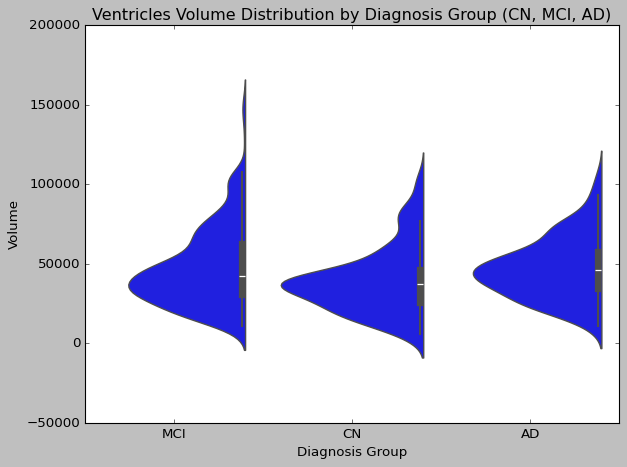

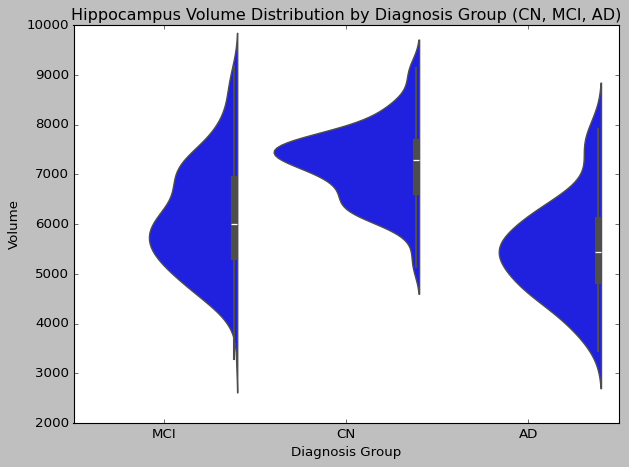

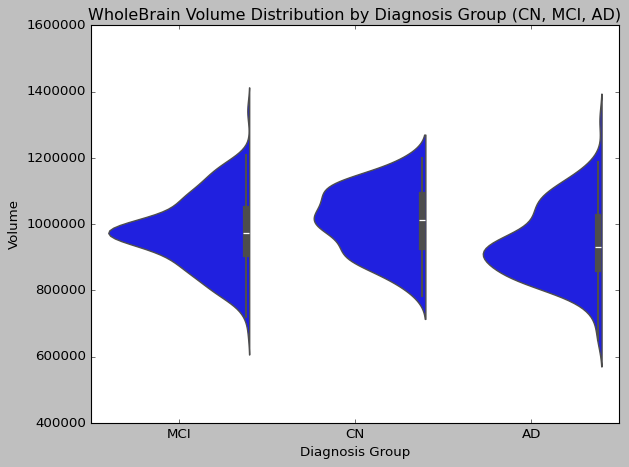

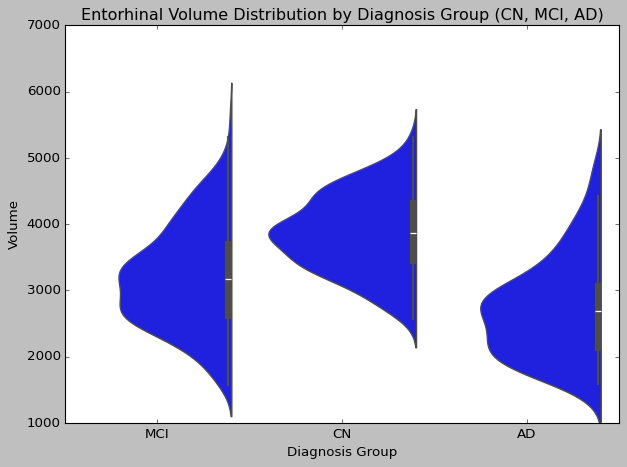

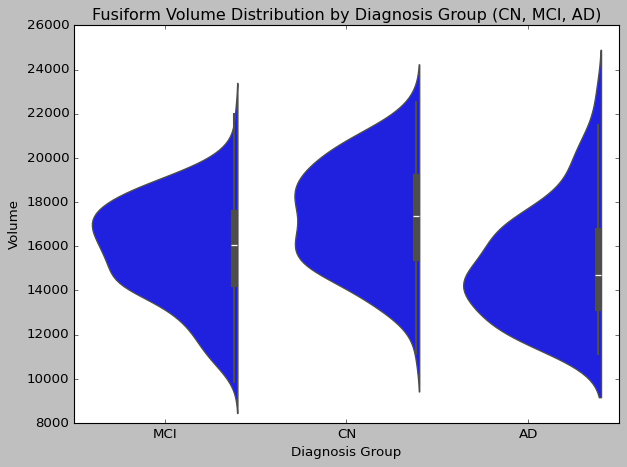

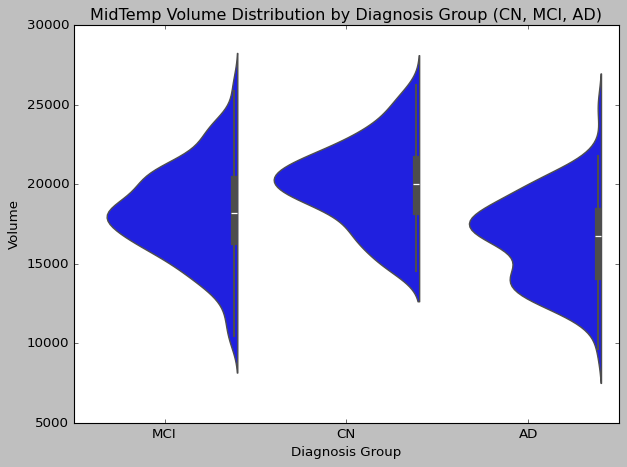

In [59]:
# Filter data by diagnosis groups
brain_regions = ['Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp']

# Create a new dataframe with volumes and diagnosis
df_plot = df_adnimerge[['DX'] + brain_regions]

# Create a separate violin plot for each brain region
for region in brain_regions:
    plt.figure(figsize=(8, 6))
    
    # Plot the distribution of volumes by diagnosis for the current brain region
    sns.violinplot(x='DX', y=region, data=df_plot, split=True)
    
    # Set the title and labels
    plt.title(f'{region} Volume Distribution by Diagnosis Group (CN, MCI, AD)')
    plt.ylabel('Volume')
    plt.xlabel('Diagnosis Group')
    
    # Display the plot
    plt.tight_layout()
    plt.show()